# Preparation

## Loading libraries

In [560]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.linear_model as lmodel
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
%matplotlib inline 


plt.style.use('seaborn-bright')
plt.rc('font', size=15) 
colors = ["#1f18da", "#e42d5b", "#00d8a3", "#313131", "#ffb92a"]
sns.set_palette(sns.color_palette(colors))

## Load data

In [561]:
df = pd.read_csv(
    "./coffee-modified.csv", sep=",")

print("Elements: {}".format(df.size))
print("Shape: {}".format(df.shape))

Elements: 58036
Shape: (1319, 44)


## Look at data

In [562]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     1312 non-null   object 
 1   Species                1319 non-null   object 
 2   Owner                  1310 non-null   object 
 3   Country.of.Origin      1316 non-null   object 
 4   Farm.Name              961 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1007 non-null   object 
 7   ICO.Number             1169 non-null   object 
 8   Company                1105 non-null   object 
 9   Altitude               1092 non-null   object 
 10  Region                 1257 non-null   object 
 11  Producer               1084 non-null   object 
 12  Number.of.Bags         1314 non-null   object 
 13  Bag.Weight             1314 non-null   object 
 14  In.Country.Partner     1314 non-null   object 
 15  Harv

In [563]:
pd.set_option("max_columns", 100)
df.transpose()

0     \
ID                                                            1   
Species                                                 Arabica   
Owner                                                 metad plc   
Country.of.Origin                                      Ethiopia   
Farm.Name                                             metad plc   
Lot.Number                                                  NaN   
Mill                                                  metad plc   
ICO.Number                                            2014/2015   
Company                       metad agricultural developmet plc   
Altitude                                              1950-2200   
Region                                             guji-hambela   
Producer                                              METAD PLC   
Number.of.Bags                                              300   
Bag.Weight                                                60 kg   
In.Country.Partner           METAD Agricultural Development plc   
Harvest.Year                                               2014   
Grading.Date                                    April 4th, 2015   
Owner.1                                               metad plc   
Variety                                                     NaN   
Processing.Method                                  Washed / Wet   
Aroma                                                      8.67   
Flavor                                                     8.83   
Aftertaste                                                 8.67   
Acidity                                                    8.75   
Body                                                        8.5   
Balance                                                    8.42   
Uniformity                                                 10.0   
Clean.Cup                                                  10.0   
Sweetness                                                  10.0   
Cupper.Points                                              8.75   
Total.Cup.Points                                          90.58   
Moisture                                                   0.12   
Category.One.Defects                                          0   
Quakers                                                       0   
Color                                                     Green   
Category.Two.Defects                                        0.0   
Expiration                                      April 3rd, 2016   
Certification.Body           METAD Agricultural Development plc   
Certification.Address  309fcf77415a3661ae83e027f7e5f05dad786e44   
Certification.Contact  19fef5a731de2db57d16da10287413f5f99bc2dd   
unit_of_measurement                                           m   
altitude_low_meters                                      1950.0   
altitude_high_meters                                     2200.0   
altitude_mean_meters                                     2075.0   

                                                           1     \
ID                                                            2   
Species                                                 Arabica   
Owner                                                 metad plc   
Country.of.Origin                                      Ethiopia   
Farm.Name                                             metad plc   
Lot.Number                                                  NaN   
Mill                                                  metad plc   
ICO.Number                                            2014/2015   
Company                       metad agricultural developmet plc   
Altitude                                              1950-2200   
Region                                             guji-hambela   
Producer                                              METAD PLC   
Number.of.Bags                                              300   
Bag.Weight                                                60 kg   
In.Country.Partner           METAD Agr

## Clean data

### Defining cleaning functions

In [564]:
def copy_df(df):
    df_copy = df.copy()
    return df_copy

In [565]:
def drop_rows_with_undefined_vals(df, col):
    isList = isinstance(col, list)
    subset = col if isList else [col]
    entries_before = df.shape[0]
    df.dropna(subset=subset, inplace=True)
    entries_after = df.shape[0]
    print("Removed {} entries in column {} containing undefined or missing values.".format(entries_before - entries_after, col))

    return df


In [566]:
def convert_data_types(df):
    df = df.convert_dtypes()
    return df

In [567]:
def select_only_species(df, species):
    entries_before = df.shape[0]
    df = df[df.Species == species]
    entries_after = df.shape[0]
    print("Removed {} entries not being of Species {}.".format(entries_before - entries_after, species))
    return df

In [568]:
def drop_unnecessary_cols(df, cols):
    df = df.drop(labels=cols, axis=1)
    return df

In [569]:
def convert_to_string(df, col):
    df[col] = df[col].astype('|S')
    return df

In [570]:
def convert_to_num(df, col):
    df[col] = pd.to_numeric(df[col])
    return df


In [571]:
def convert_to_int(df, col):
    df[col] = df[col].astype("int32")
    return df

In [572]:
def correct_altitude_values(df):
    #select row whrere region is of type cerrado and altitude is higher than 5000; move comma by one position to land in correct range (decimeter -> meter)
    df.loc[(df.Region == "cerrado") & (df["altitude_mean_meters"] > 5000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] = df.loc[(df.Region == "cerrado") & (df["altitude_mean_meters"] > 5000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] / 10

    #take every row above 6000 meters and convert from cm to meters by dividing by 100
    df.loc[(df["altitude_mean_meters"] > 6000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] = df.loc[(df["altitude_mean_meters"] > 6000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] / 100
    return df

In [573]:
def remove_zero_total_cup_results(df):
    entries_before = df.shape[0]
    df = df[df["Total.Cup.Points"] > 0]
    entries_after = df.shape[0]
    print("Removed {} entries where total cup results were equal to zero.".format(entries_before - entries_after))
    return df

In [574]:
def remove_none_values(df, col):
    entries_before = df.shape[0]
    df = df[~df[col].isin(["None", "none"])]
    entries_after = df.shape[0]
    print("Removed {} entries from {} because they were None/none.".format((entries_before - entries_after), col))
    return df

In [575]:
def remove_kg_units_from_weight(df):
    df["Bag.Weight"] = df["Bag.Weight"].apply(lambda row: str.replace(row, " kg", ""))
    return df

In [576]:
def remove_lbs_units_from_weight(df):
    df["Bag.Weight"] = df["Bag.Weight"].apply(lambda row: str.replace(row, " lbs", ""))
    return df

In [577]:
def calculate_total_weight(df):
    df["Weight.Total"] = df["Bag.Weight.Kg"] * df["Number.of.Bags"]
    return df

In [578]:
def convert_weight_to_kg(df):
    df["Bag.Weight.Kg"] = df.apply(pound_kg_conversion, axis=1)
    return df


def pound_kg_conversion(row):
    weight = row["Bag.Weight"]
    if "kg" in weight:
        return str.replace(weight, " kg", "")
    elif "lbs" in weight:
        weight = str.replace(weight, " lbs", "")
        weight_int = int(weight)
        return 0.453592 * weight_int



In [579]:
def remove_outliers(df, col):
    entries_before = df.shape[0]
    df = df[(np.abs(stats.zscore(df[col])) < 3)]
    entries_after = df.shape[0]
    print("Removed {} entries from {} because they were outliers.".format((entries_before - entries_after), col))
    return df

In [580]:
def dummify(df, col):

    dum = pd.get_dummies(df[col], prefix=col, prefix_sep=".")
    df = pd.concat([df, dum], axis=1)
    return df

### Piping dataframe through cleaning functions

In [581]:
metric_features = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body",
                   "Balance", "Uniformity", "Clean.Cup", "Sweetness", "Cupper.Points"]
df_type_adjusted = (df.pipe(copy_df)
                    .pipe(convert_data_types)
                    .pipe(drop_rows_with_undefined_vals, metric_features)
                    .pipe(drop_rows_with_undefined_vals, "Total.Cup.Points")
                    .pipe(drop_rows_with_undefined_vals, "Color")
                    .pipe(convert_to_num, "Cupper.Points")
                    .pipe(convert_to_num, "Total.Cup.Points")
                    .pipe(convert_to_num, "Number.of.Bags")
                    .pipe(convert_weight_to_kg)
                    .pipe(convert_to_num, "Bag.Weight.Kg")
                    .pipe(calculate_total_weight)

                    )
print("New data shape: {}".format(df_type_adjusted.shape))

unnecessary_cols = ["Lot.Number", "Farm.Name", "Mill", "Company", "Altitude", "Producer", "In.Country.Partner",
                    "Owner.1", "Certification.Address", "Certification.Contact", "Owner", "Certification.Body"]

df_cleaned = (df.pipe(copy_df)
                .pipe(convert_data_types)
                .pipe(drop_unnecessary_cols, unnecessary_cols)
                .pipe(drop_rows_with_undefined_vals, metric_features)
                .pipe(drop_rows_with_undefined_vals, "Total.Cup.Points")
                .pipe(drop_rows_with_undefined_vals, "Color")
                .pipe(drop_rows_with_undefined_vals, "Processing.Method")
                .pipe(drop_rows_with_undefined_vals, "altitude_low_meters")
                .pipe(drop_rows_with_undefined_vals, "altitude_high_meters")
                .pipe(drop_rows_with_undefined_vals, "altitude_mean_meters")
                .pipe(remove_none_values, "Color")
                .pipe(dummify, "Color")
                .pipe(select_only_species, "Arabica")
                .pipe(convert_to_num, "Cupper.Points")
                .pipe(convert_to_num, "Total.Cup.Points")
                .pipe(convert_to_num, "Quakers")
                .pipe(convert_to_num, "Number.of.Bags")
                .pipe(convert_weight_to_kg)
                .pipe(convert_to_num, "Bag.Weight.Kg")
                .pipe(remove_zero_total_cup_results)
                .pipe(correct_altitude_values)
                .pipe(calculate_total_weight)
                .pipe(remove_outliers, "Weight.Total")
              )
print("New data shape: {}".format(df_cleaned.shape))


Removed 12 entries in column ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points'] containing undefined or missing values.
Removed 0 entries in column Total.Cup.Points containing undefined or missing values.
Removed 215 entries in column Color containing undefined or missing values.
New data shape: (1092, 46)
Removed 12 entries in column ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points'] containing undefined or missing values.
Removed 0 entries in column Total.Cup.Points containing undefined or missing values.
Removed 215 entries in column Color containing undefined or missing values.
Removed 32 entries in column Processing.Method containing undefined or missing values.
Removed 134 entries in column altitude_low_meters containing undefined or missing values.
Removed 0 entries in column altitude_high_meters containing undefined or missing values.
Remov

## Look at data after cleaning

In [582]:
print(df_cleaned.info())
print(df_cleaned["Color"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 1317
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    875 non-null    string 
 1   Species               875 non-null    string 
 2   Country.of.Origin     875 non-null    string 
 3   ICO.Number            788 non-null    string 
 4   Region                874 non-null    string 
 5   Number.of.Bags        875 non-null    int64  
 6   Bag.Weight            875 non-null    string 
 7   Harvest.Year          870 non-null    string 
 8   Grading.Date          875 non-null    string 
 9   Variety               851 non-null    string 
 10  Processing.Method     875 non-null    string 
 11  Aroma                 875 non-null    string 
 12  Flavor                875 non-null    string 
 13  Aftertaste            875 non-null    string 
 14  Acidity               875 non-null    string 
 15  Body                  

In [583]:
df_cleaned.transpose()

0                1                 3     \
ID                                  1                2                 4   
Species                       Arabica          Arabica           Arabica   
Country.of.Origin            Ethiopia         Ethiopia          Ethiopia   
ICO.Number                  2014/2015        2014/2015              <NA>   
Region                   guji-hambela     guji-hambela            oromia   
Number.of.Bags                    300              300               320   
Bag.Weight                      60 kg            60 kg             60 kg   
Harvest.Year                     2014             2014              2014   
Grading.Date          April 4th, 2015  April 4th, 2015  March 26th, 2015   
Variety                          <NA>            Other              <NA>   
Processing.Method        Washed / Wet     Washed / Wet     Natural / Dry   
Aroma                            8.67             8.75              8.17   
Flavor                           8.83             8.67              8.58   
Aftertaste                       8.67              8.5              8.42   
Acidity                          8.75             8.58              8.42   
Body                              8.5             8.42               8.5   
Balance                          8.42             8.42              8.25   
Uniformity                       10.0             10.0              10.0   
Clean.Cup                        10.0             10.0              10.0   
Sweetness                        10.0             10.0              10.0   
Cupper.Points                    8.75             8.58              8.67   
Total.Cup.Points                90.58            89.92              89.0   
Moisture                         0.12             0.12              0.11   
Category.One.Defects                0                0                 0   
Quakers                           0.0              0.0               0.0   
Color                           Green            Green             Green   
Category.Two.Defects                0                1                 2   
Expiration            April 3rd, 2016  April 3rd, 2016  March 25th, 2016   
unit_of_measurement                 m                m                 m   
altitude_low_meters            1950.0           1950.0            1800.0   
altitude_high_meters           2200.0           2200.0            2200.0   
altitude_mean_meters           2075.0           2075.0            2000.0   
Color.Blue-Green                    0                0                 0   
Color.Bluish-Green                  0                0                 0   
Color.Green                         1                1                 1   
Bag.Weight.Kg                    60.0             60.0              60.0   
Weight.Total                  18000.0          18000.0           19200.0   

                                 4                            9     \
ID                                  5                           10   
Species                       Arabica                      Arabica   
Country.of.Origin            Ethiopia                     Ethiopia   
ICO.Number                  2014/2015                      2014/15   
Region                   guji-hambela  snnp/kaffa zone,gimbowereda   
Number.of.Bags                    300                           50   
Bag.Weight                      60 kg                        60 kg   
Harvest.Year                     2014                         2014   
Grading.Date          April 4th, 2015             March 30th, 2015   
Variety                         Other                        Other   
Processing.Method        Washed / Wet                Natural / Dry   
Aroma                            8.25                         8.08   
Flavor                            8.5                         8.58   
Aftertaste                       8.25                          8.5   
Acidity                           8.5                          8.5   
Body                    

# Data analysis

## Distributions

### Countries

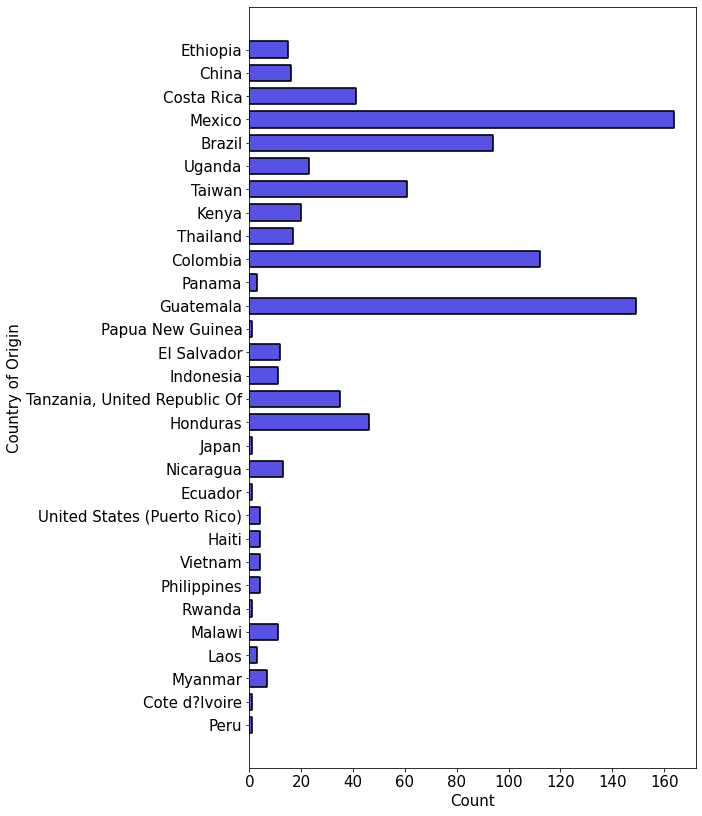

In [584]:
plt.figure(figsize=(8, 14))
ax = sns.histplot(data=df_cleaned, y="Country.of.Origin", shrink=.7);
ax.set(ylabel="Country of Origin");

### Altitude

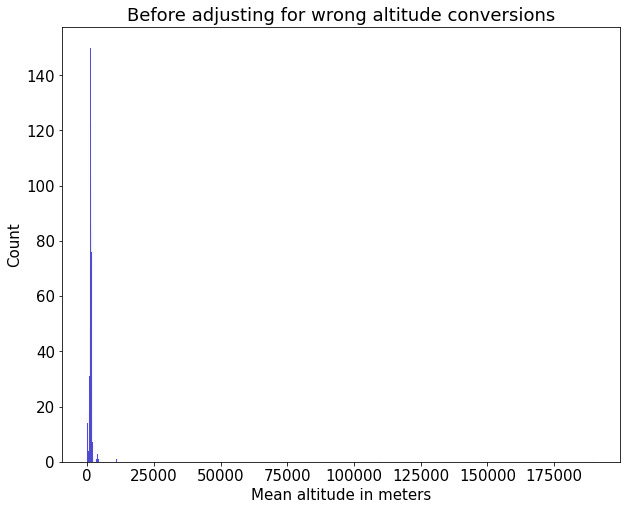

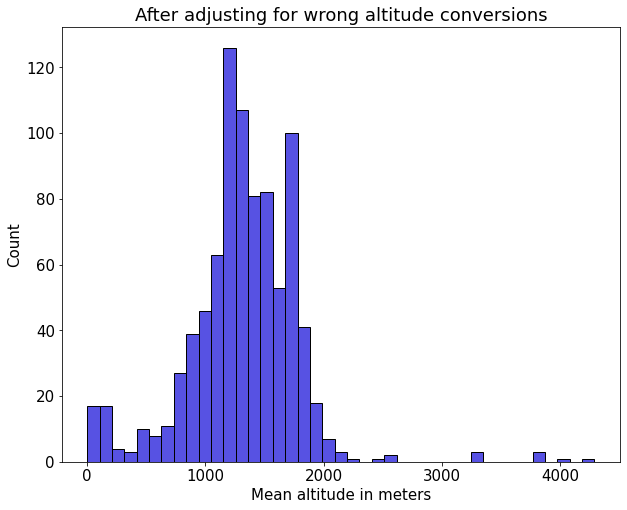

In [585]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df, x="altitude_mean_meters")
ax.set(xlabel="Mean altitude in meters", title="Before adjusting for wrong altitude conversions");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="altitude_mean_meters")
ax.set(xlabel="Mean altitude in meters", title="After adjusting for wrong altitude conversions");

### Cupping results

Overall average of tested beans: 82.17281142857144
Overall standard deviation of tested beans: 2.567968701887508
Minimum of tested beans: 59.83
Maximum of tested beans: 90.58


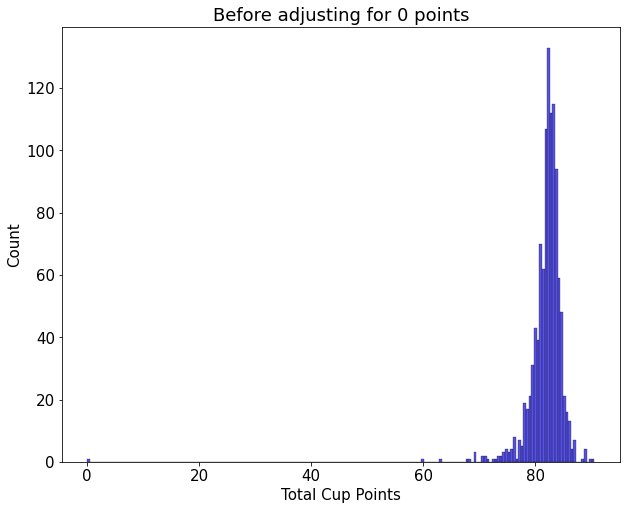

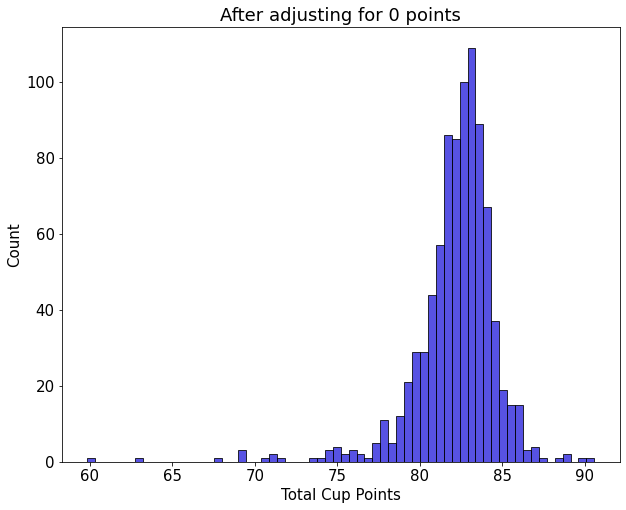

In [586]:
print("Overall average of tested beans: {}".format(df_cleaned["Total.Cup.Points"].mean()))
print("Overall standard deviation of tested beans: {}".format(df_cleaned["Total.Cup.Points"].std()))
print("Minimum of tested beans: {}".format(df_cleaned["Total.Cup.Points"].min()))
print("Maximum of tested beans: {}".format(df_cleaned["Total.Cup.Points"].max()))

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_type_adjusted, x="Total.Cup.Points")
ax.set(xlabel="Total Cup Points", title="Before adjusting for 0 points");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="Total.Cup.Points")
ax.set(xlabel="Total Cup Points", title="After adjusting for 0 points");

<Figure size 720x1440 with 0 Axes>

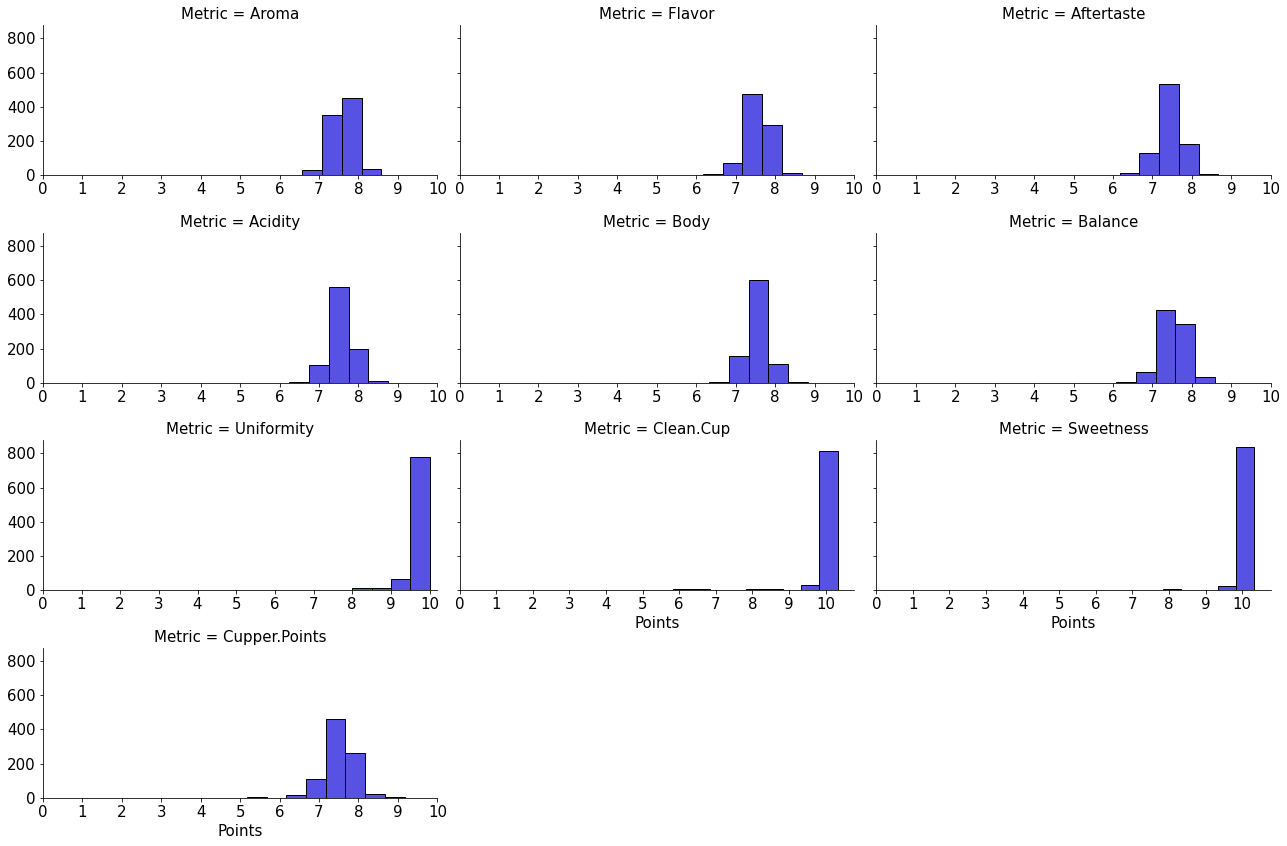

In [587]:
df_melted = df_cleaned.melt(value_vars=metric_features, var_name="Metric")
df_melted = df_melted.round(2)
df_melted["value"] = df_melted["value"].astype("float64")

plt.figure(figsize=(10, 20))
g = sns.FacetGrid(df_melted, col='Metric', col_wrap=3, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, "value", binwidth=0.5)
g.set(xticks=range(0, 11, 1))
g.set_xlabels("Points")


### Color


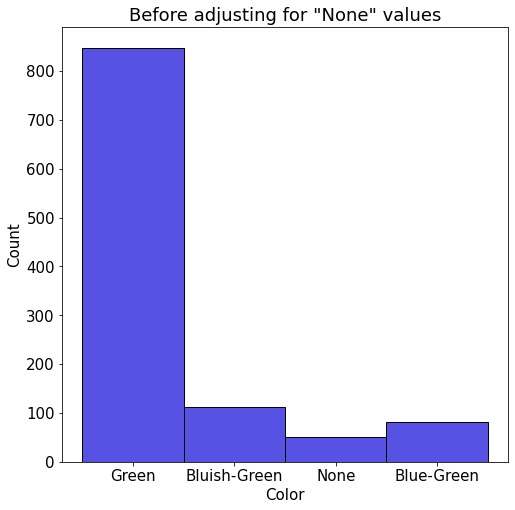

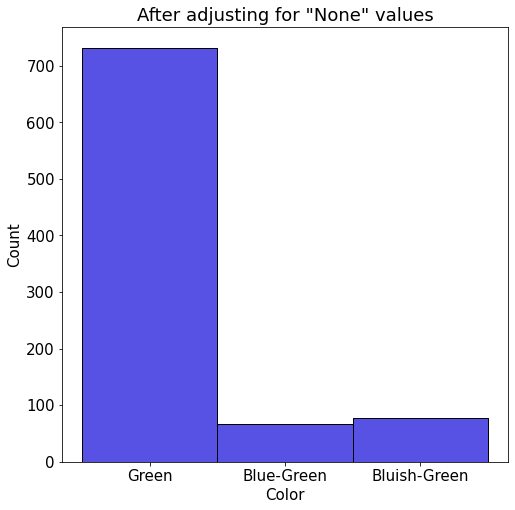

In [588]:
plt.figure(figsize=(8, 8))
ax = sns.histplot(data=df_type_adjusted, x="Color")
ax.set(xlabel="Color", title="Before adjusting for \"None\" values");


plt.figure(figsize=(8, 8))
ax = sns.histplot(data=df_cleaned, x="Color")
ax.set(xlabel="Color", title="After adjusting for \"None\" values");

### Processing Method

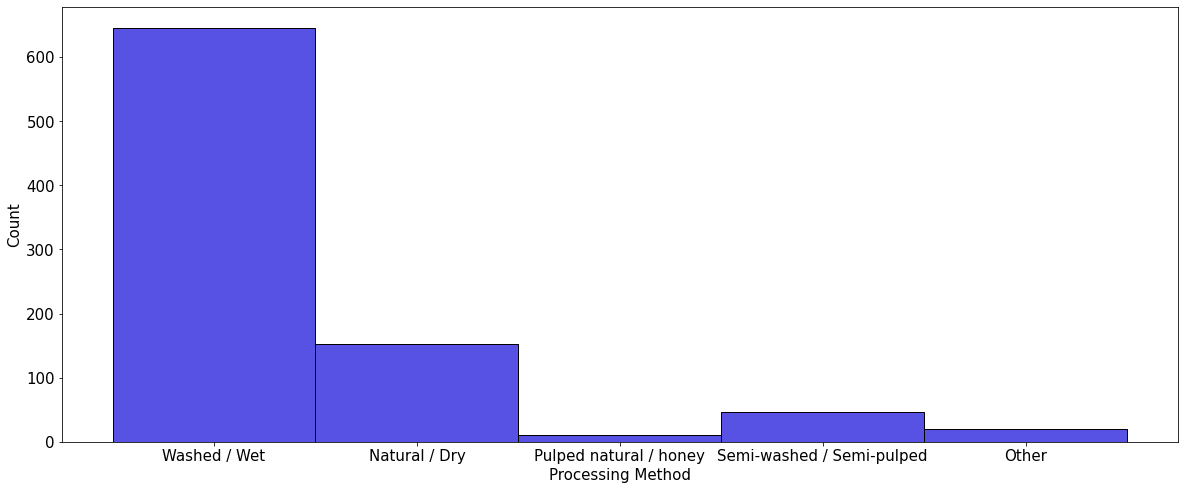

In [589]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(data=df_cleaned, x="Processing.Method")
ax.set(xlabel="Processing Method");

### Total weight

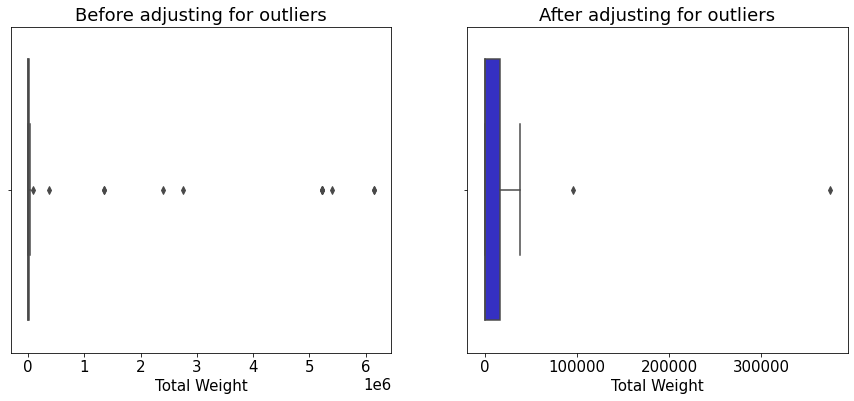

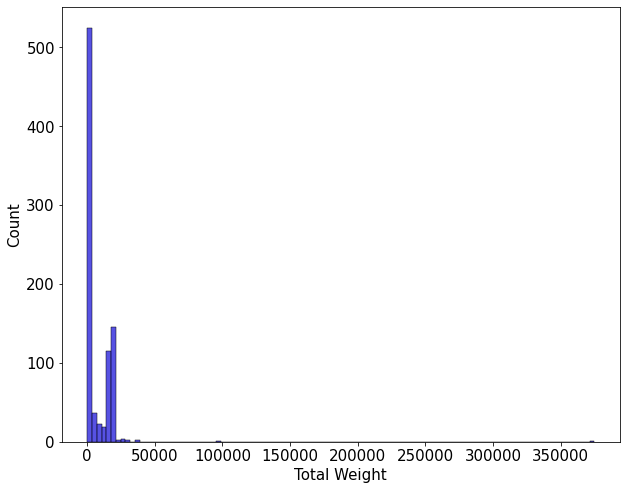

In [590]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6));
sns.boxplot(x=df_type_adjusted["Weight.Total"], ax=ax1)
ax1.set(xlabel="Total Weight", title="Before adjusting for outliers");

sns.boxplot(x=df_cleaned["Weight.Total"], ax=ax2);
ax2.set(xlabel="Total Weight", title="After adjusting for outliers");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="Weight.Total")
ax.set(xlabel="Total Weight");

### Defects

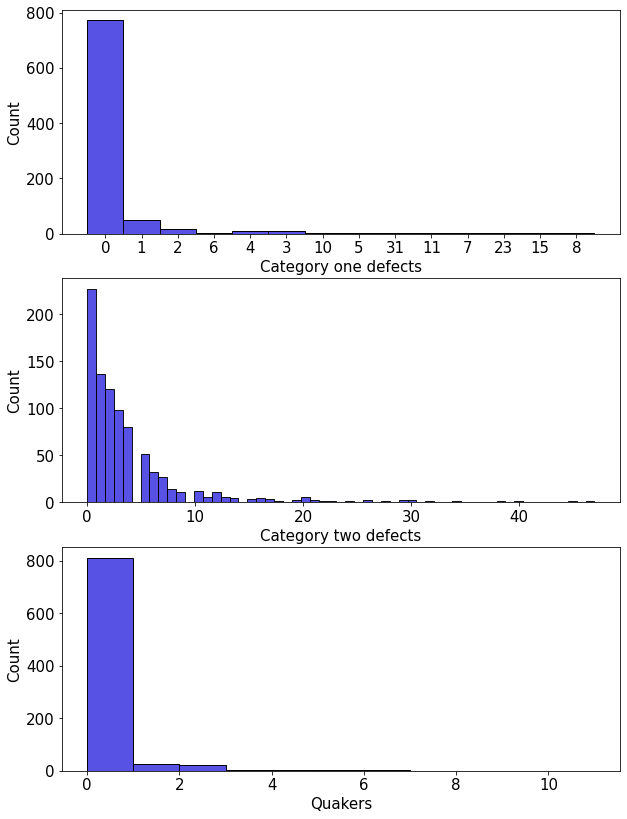

In [591]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 14))
sns.histplot(data=df_cleaned, x="Category.One.Defects", ax=ax1)
ax1.set(xlabel="Category one defects");

sns.histplot(data=df_cleaned, x="Category.Two.Defects", ax=ax2)
ax2.set(xlabel="Category two defects");

sns.histplot(data=df_cleaned, x="Quakers", ax=ax3)
ax3.set(xlabel="Quakers");

## Correlations

### Weight

(0.08898810289034581, 0.00844433163077464)
SpearmanrResult(correlation=0.2267672351070763, pvalue=1.1458301091981688e-11)


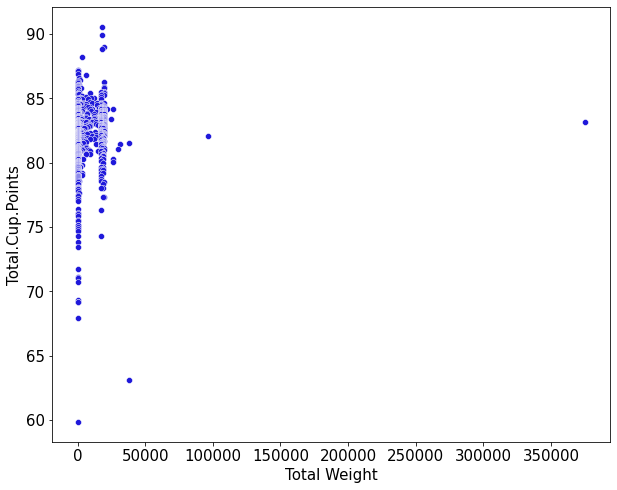

In [592]:
x = df_cleaned["Weight.Total"]
y = df_cleaned["Total.Cup.Points"]

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(y=y, x=x)
ax.set(xlabel="Total Weight");
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

Pearson coefficient for metric Aroma: (0.06946288500062434, 0.039948179941986135)
Spearman coefficient for metric Aroma: SpearmanrResult(correlation=0.15347795530886954, pvalue=5.103320929850375e-06)
Pearson coefficient for metric Flavor: (0.07947223364661375, 0.018714004544577265)
Spearman coefficient for metric Flavor: SpearmanrResult(correlation=0.16679480194336657, pvalue=6.991489108510208e-07)
Pearson coefficient for metric Aftertaste: (0.0595862177118597, 0.07813184835461506)
Spearman coefficient for metric Aftertaste: SpearmanrResult(correlation=0.1641016749847624, pvalue=1.058841768546265e-06)
Pearson coefficient for metric Acidity: (0.09675145807890166, 0.004175649126748925)
Spearman coefficient for metric Acidity: SpearmanrResult(correlation=0.18822277526542133, pvalue=2.023721792303003e-08)
Pearson coefficient for metric Body: (0.08720849117565835, 0.00985451683739553)
Spearman coefficient for metric Body: SpearmanrResult(correlation=0.226721824442707, pvalue=1.1569620999630

<Figure size 720x1440 with 0 Axes>

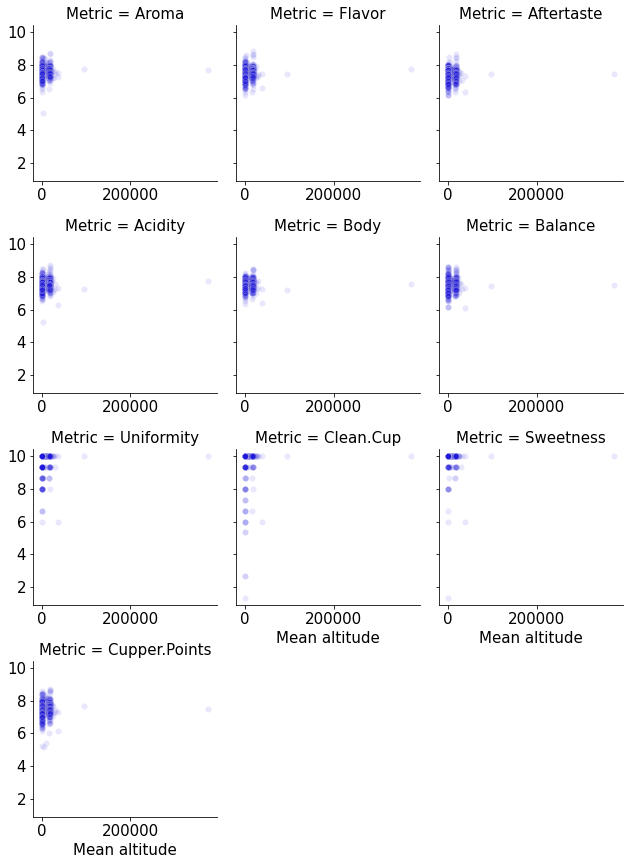

In [593]:
df_melted = df_cleaned.melt(id_vars="Weight.Total", value_vars=metric_features, var_name="Metric")
df_melted["value"] = df_melted["value"].astype("float64")

plt.figure(figsize=(10, 20))
g = sns.FacetGrid(df_melted, col='Metric', col_wrap=3, aspect=1, sharex=False)
g.map_dataframe(sns.scatterplot, y="value", x="Weight.Total", alpha=0.1)
g.set_xlabels("Mean altitude")

for name in g.col_names:
    x = df_melted[df_melted["Metric"] == name]["value"]
    y = df_melted[df_melted["Metric"] == name]["Weight.Total"]
    print("Pearson coefficient for metric {}: {}".format(name, stats.pearsonr(x, y)))
    print("Spearman coefficient for metric {}: {}".format(name, stats.spearmanr(x, y)))




### Altitude

(0.1515184107121075, 6.744944348251652e-06)
SpearmanrResult(correlation=0.253953090867028, pvalue=2.4089761365492476e-14)


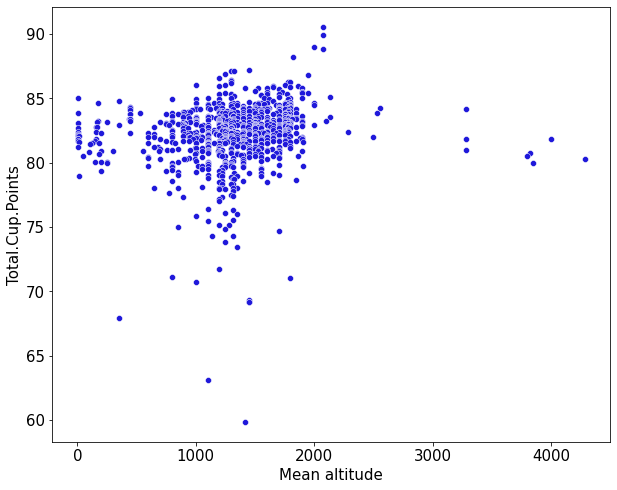

In [594]:
x = df_cleaned["altitude_mean_meters"]
y = df_cleaned["Total.Cup.Points"]

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(y=y, x=x)
ax.set(xlabel="Mean altitude");
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

Pearson coefficient for metric Aroma: (0.15186943025350336, 6.4178771301944125e-06)
Spearman coefficient for metric Aroma: SpearmanrResult(correlation=0.23013787829761476, pvalue=5.558294032124074e-12)
Pearson coefficient for metric Flavor: (0.14225749550939254, 2.4052068824301357e-05)
Spearman coefficient for metric Flavor: SpearmanrResult(correlation=0.17535478812789684, pvalue=1.787798074772944e-07)
Pearson coefficient for metric Aftertaste: (0.12804399003247036, 0.00014597363860101208)
Spearman coefficient for metric Aftertaste: SpearmanrResult(correlation=0.18683659312047138, pvalue=2.5782726999993067e-08)
Pearson coefficient for metric Acidity: (0.20728027746414754, 6.015796000786695e-10)
Spearman coefficient for metric Acidity: SpearmanrResult(correlation=0.2537142402431542, pvalue=2.5515105054761584e-14)
Pearson coefficient for metric Body: (0.11394636248482849, 0.0007334389365416546)
Spearman coefficient for metric Body: SpearmanrResult(correlation=0.16759628080868197, pvalue=

<Figure size 720x1440 with 0 Axes>

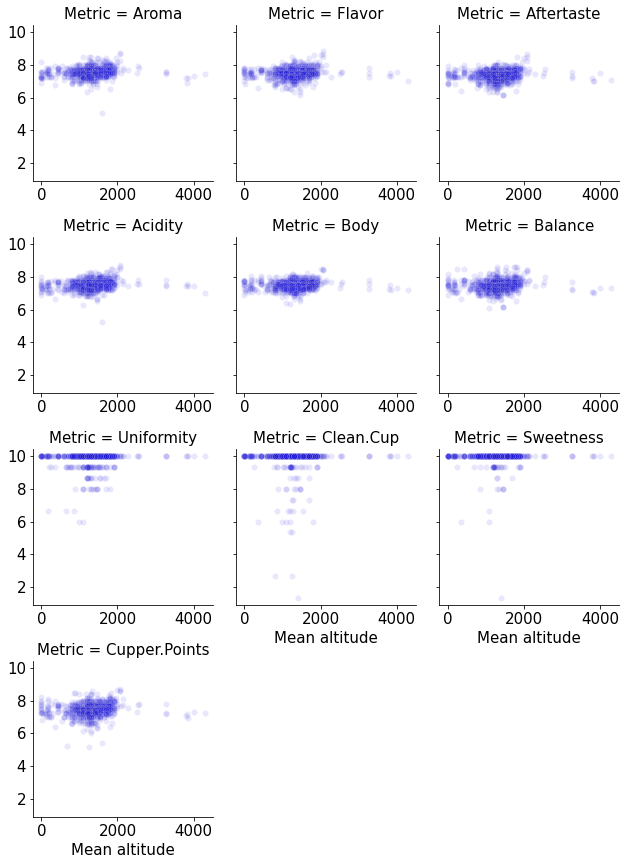

In [595]:
df_melted = df_cleaned.melt(id_vars=["altitude_mean_meters"], value_vars=metric_features, var_name="Metric")
df_melted["value"] = df_melted["value"].astype("float64")

plt.figure(figsize=(10, 20))
g = sns.FacetGrid(df_melted, col='Metric', col_wrap=3, aspect=1, sharex=False)
g.map_dataframe(sns.scatterplot, y="value", x="altitude_mean_meters", alpha=0.1)
g.set_xlabels("Mean altitude")

for name in g.col_names:
    x = df_melted[df_melted["Metric"] == name]["value"]
    y = df_melted[df_melted["Metric"] == name]["altitude_mean_meters"]
    print("Pearson coefficient for metric {}: {}".format(name, stats.pearsonr(x, y)))
    print("Spearman coefficient for metric {}: {}".format(name, stats.spearmanr(x, y)))




### Color

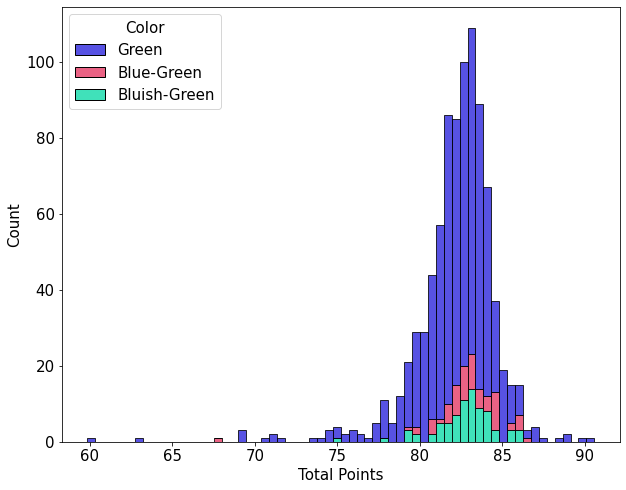

In [596]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="Total.Cup.Points", hue="Color", multiple="stack")
ax.set(xlabel="Total Points");

In [610]:
color_cols = ["Color.Green", "Color.Blue-Green", "Color.Bluish-Green"]
x = df_cleaned[color_cols].values
y = df_cleaned["Total.Cup.Points"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


ridge = lmodel.RidgeCV(alphas=np.arange(0.01, 100, 0.01)).fit(x_train, y_train)
print("Score of {}: {}".format("Combined", ridge.score(x_test, y_test)))
print("Alpha of {}: {}".format("Combined", ridge.alpha_))

regr = svm.SVR()
params = [{"kernel": ["linear"], "C": np.arange(1, 1000, 10)}, {"kernel": ["rbf"], "C": np.arange(1, 1000, 10)}]
clf = GridSearchCV(regr, params)
clf.fit(x_train, y_train)

print(clf.best_params_)
print(clf.best_score_)


for col in color_cols:
    x = df_cleaned[col].values.reshape(-1, 1)
    y = df_cleaned["Total.Cup.Points"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    clf = lmodel.RidgeCV(alphas=np.arange(0.01, 100, 0.01)).fit(x_train, y_train)
    print("Score of {}: {}".format(col, clf.score(x_test, y_test)))
    print("Alpha of {}: {}".format(col, clf.alpha_))



Score of Combined: -0.006159308569028132
Alpha of Combined: 16.400000000000002
{'C': 61, 'kernel': 'linear'}
-0.007322431098659621
Score of Color.Green: -0.013857768714490959
Alpha of Color.Green: 9.64
Score of Color.Blue-Green: -0.01273465525371087
Alpha of Color.Blue-Green: 40.449999999999996
Score of Color.Bluish-Green: 0.0023040561321030495
Alpha of Color.Bluish-Green: 15.6


### Processing Method

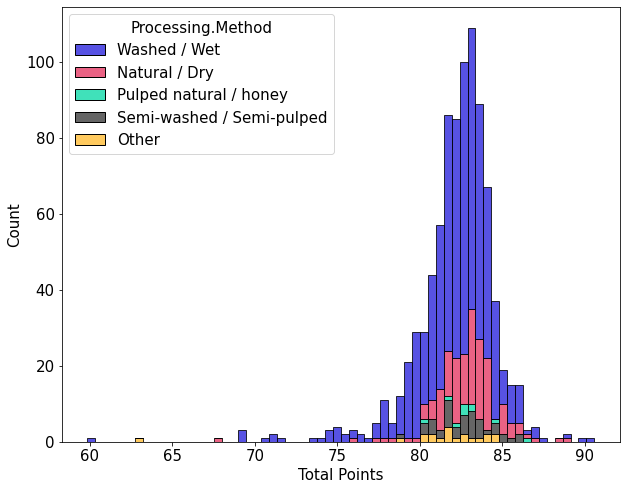

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="Total.Cup.Points", hue="Processing.Method", multiple="stack")
ax.set(xlabel="Total Points");